In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/..
!pip install -q --upgrade transformers scikit-learn pandas matplotlib seaborn scipy

/content/drive/MyDrive
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


Starting multi-task BERT model training
Loading and preprocessing data...
Normalizing RFU data...
Splitting off the test set (10%)...
Splitting train and validation sets from remaining data (80% train, 9% val)...

Final data distribution:
Train distribution:
cpp_label
1.0    149
0.0    148
Name: count, dtype: int64
Validation distribution:
cpp_label
0.0    17
1.0    17
Name: count, dtype: int64
Test distribution:
cpp_label
0.0    19
1.0    18
Name: count, dtype: int64

Final sizes: Total: 693
Train: 560 (80.8%)
Validation: 63 (9.1%)
Test: 70 (10.1%)


/content/drive/MyDrive/training/trainer.py:26: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Total parameters: 421,313,155
Trainable parameters: 52,816,515
Starting training...
🚀 Iniciando entrenamiento mejorado por 40 épocas...
📦 Modelo: BertMultiTaskModel
🎯 Paciencia: 12
📱 Dispositivo: cuda
⚖️  Alpha (RFU): 1.00, Beta (CPP): 0.80
🔥 Warmup epochs: 3


Confianza promedio CPP: 0.695 ± 0.131


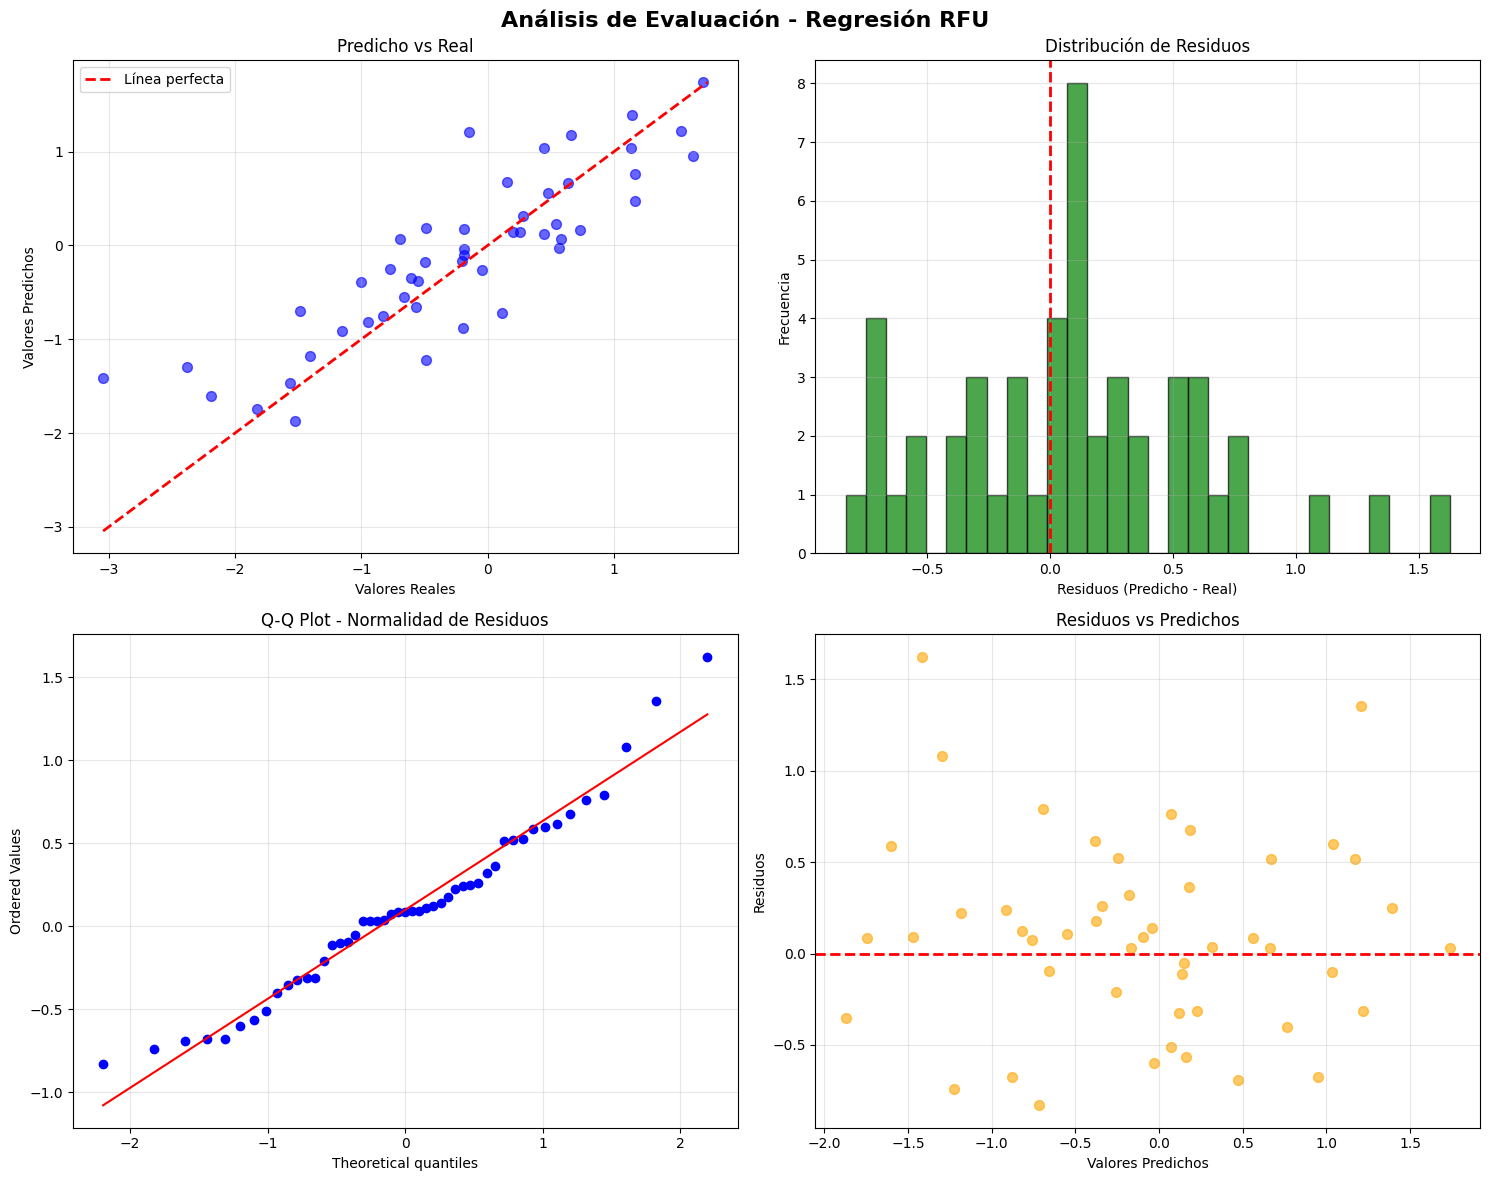

Análisis detallado: 100%|██████████| 9/9 [00:04<00:00,  1.99it/s]



ANÁLISIS ESTADÍSTICO DETALLADO:
   RFU - Estadísticas de Predicción:
   Media predicha: 1.4724 ± 0.5584
   Media real: 1.4089 ± 0.6705
   Rango predicho: [0.3417, 2.6584]
   Rango real: [-0.4089, 2.6388]
   Percentiles predichos: [0.69443645 1.08461739 1.51612264 1.84572361 2.22935641]
   Percentiles reales: [0.56193697 1.04805317 1.42439155 1.89148171 2.27863241]

 CPP - Estadísticas de Clasificación:
   Distribución predicha: [20 17]
   Distribución real: [19 18]
   Confianza promedio: 0.6945 ± 0.1315
   Predicciones de alta confianza (>0.9): 3/37


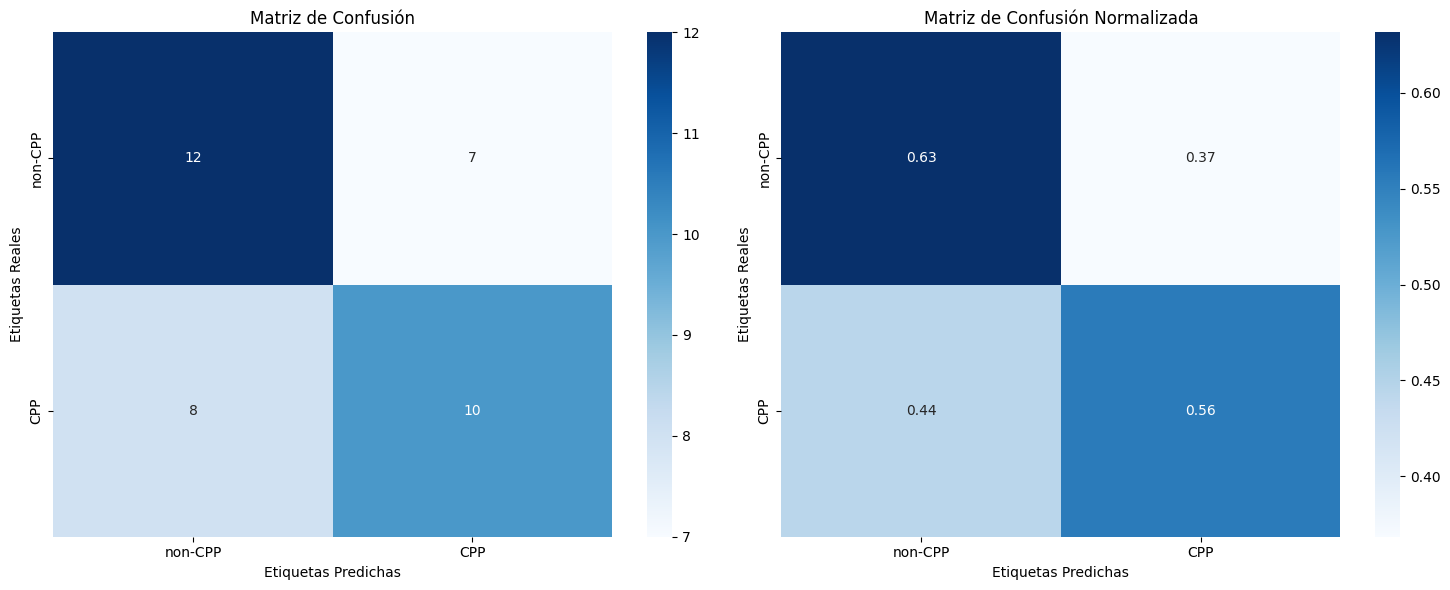


Reporte de Clasificación:
              precision    recall  f1-score   support

     non-CPP       0.60      0.63      0.62        19
         CPP       0.59      0.56      0.57        18

    accuracy                           0.59        37
   macro avg       0.59      0.59      0.59        37
weighted avg       0.59      0.59      0.59        37

 Análisis detallado completado
Model configuration saved at ./saved_model/model_config.json


In [ ]:
import os
import json
import joblib
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from transformers import BertTokenizer
from datetime import datetime
from data.dataset import MultiTaskPeptideDataset
from model.model import BertMultiTaskModel, FocalLoss, HuberLoss
from training.trainer import train_improved, evaluate_improved, detailed_analysis
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

def main():
    print("Starting multi-task BERT model training")
    print("="*60)

    # Set seeds for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(42)
        torch.cuda.manual_seed_all(42)

    # Load data
    print("Loading and preprocessing data...")
    df = pd.read_csv("./data/data_cpp_rfu_merge.csv")
    df = df.rename(columns={'peptide': 'sequence', 'y_df1': 'cpp_label', 'y_df2': 'rfu_label'})

    # Clean data
    df = df.dropna(subset=['sequence'])
    df['sequence'] = df['sequence'].astype(str)

    # Normalize RFU
    print("Normalizing RFU data...")
    scaler = StandardScaler()
    non_null_rfu = df['rfu_label'].dropna().values.reshape(-1, 1)
    if non_null_rfu.size > 0:
        scaler.fit(non_null_rfu)
        df.loc[df['rfu_label'].notna(), 'rfu_label'] = scaler.transform(non_null_rfu).flatten()
        joblib.dump(scaler, "./saved_model/scaler.pkl")

    # Stratified split
    print("Splitting off the test set (10%)...")
    stratify_var = df['cpp_label'].fillna(-999).astype(int)
    train_val_df, test_df = train_test_split(df, test_size=0.10, random_state=42, stratify=stratify_var)

    print("Splitting train and validation sets from remaining data (80% train, 9% val)...")
    stratify_var_tv = train_val_df['cpp_label'].fillna(-999).astype(int)
    train_df, val_df = train_test_split(train_val_df, test_size=0.10, random_state=42, stratify=stratify_var_tv)

    print("\nFinal data distribution:")
    print(f"Train distribution:\n{train_df['cpp_label'].value_counts()}")
    print(f"Validation distribution:\n{val_df['cpp_label'].value_counts()}")
    print(f"Test distribution:\n{test_df['cpp_label'].value_counts()}")

    print(f"\nFinal sizes: Total: {len(df)}")
    print(f"Train: {len(train_df)} ({len(train_df)/len(df):.1%})")
    print(f"Validation: {len(val_df)} ({len(val_df)/len(df):.1%})")
    print(f"Test: {len(test_df)} ({len(test_df)/len(df):.1%})")


    # Configure datasets and loaders
    tokenizer = BertTokenizer.from_pretrained("Rostlab/prot_bert", do_lower_case=False)

    train_dataset = MultiTaskPeptideDataset(
        train_df['sequence'].tolist(), train_df['rfu_label'].tolist(),
        train_df['cpp_label'].tolist(), tokenizer, max_length=256
    )
    val_dataset = MultiTaskPeptideDataset(
        val_df['sequence'].tolist(), val_df['rfu_label'].tolist(),
        val_df['cpp_label'].tolist(), tokenizer, max_length=256
    )
    test_dataset = MultiTaskPeptideDataset(
        test_df['sequence'].tolist(), test_df['rfu_label'].tolist(),
        test_df['cpp_label'].tolist(), tokenizer, max_length=256
    )

    # DataLoaders
    batch_size = 8 if torch.cuda.is_available() else 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                             num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=2,
                           pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=2,
                            pin_memory=True)

    # Model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = BertMultiTaskModel(dropout=0.3, pooling_strategy='mean').to(device)

    # Optimizer
    bert_params = []
    head_params = []

    for name, param in model.named_parameters():
        if 'bert' in name:
            bert_params.append(param)
        else:
            head_params.append(param)

    optimizer = AdamW([
        {'params': bert_params, 'lr': 1e-5, 'initial_lr': 1e-5},
        {'params': head_params, 'lr': 5e-5, 'initial_lr': 5e-5}
    ], weight_decay=0.01, eps=1e-8)

    # Scheduler
    scheduler = ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=6, verbose=True, min_lr=1e-8
    )

    # Loss functions
    loss_fn_rfu = HuberLoss(delta=0.5, reduction='mean')
    loss_fn_cpp = FocalLoss(alpha=1, gamma=2, reduction='mean')

    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
    print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    # Training
    print("Starting training...")
    EPOCHS = 40
    alpha = 1.0  # RFU weight
    beta = 0.8   # CPP weight

    train_loss, best_rmse = train_improved(
        model=model, train_loader=train_loader, val_loader=val_loader,
        optimizer=optimizer, scheduler=scheduler, loss_fn_rfu=loss_fn_rfu,
        loss_fn_cpp=loss_fn_cpp, device=device, epochs=EPOCHS, patience=12,
        alpha=alpha, beta=beta, warmup_epochs=3
    )

    # Final evaluation
    print("Final evaluation on test set...")
    rmse, mae, r2, accuracy, f1 = evaluate_improved(
        model, test_loader, device, loss_fn_rfu, loss_fn_cpp, save_plots=True
    )

    print("\n" + "="*60)
    print("FINAL RESULTS:")
    print("="*60)
    print(f" RMSE (RFU): {rmse:.4f}")
    print(f" MAE (RFU): {mae:.4f}")
    print(f" R² (RFU): {r2:.4f}")
    print(f" Accuracy (CPP): {accuracy:.4f}")
    print(f" F1-Score (CPP): {f1:.4f}")
    print("="*60)

    # Save final metrics
    final_metrics = {
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'accuracy': accuracy,
        'f1_score': f1,
        'train_loss': train_loss,
        'total_params': sum(p.numel() for p in model.parameters()),
        'trainable_params': sum(p.numel() for p in model.parameters() if p.requires_grad),
        'timestamp': datetime.now().isoformat()
    }

    with open('./saved_model/final_metrics.json', 'w') as f:
        json.dump(final_metrics, f, indent=2)

    print("Final metrics saved at ./saved_model/final_metrics.json")

    # Detailed analysis
    print("\nPerforming detailed analysis...")
    detailed_analysis(model, test_loader, device, scaler)

    # Save model configuration
    model_config = {
        'model_class': 'BertMultiTaskModel',
        'base_model': 'Rostlab/prot_bert',
        'dropout': 0.3,
        'pooling_strategy': 'mean',
        'max_length': 256,
        'batch_size': batch_size,
        'epochs_trained': EPOCHS,
        'optimizer': 'AdamW',
        'scheduler': 'ReduceLROnPlateau',
        'loss_functions': {
            'rfu': 'HuberLoss',
            'cpp': 'FocalLoss'
        },
        'task_weights': {
            'alpha': alpha,
            'beta': beta
        }
    }

    with open('./saved_model/model_config.json', 'w') as f:
        json.dump(model_config, f, indent=2)

    print("Model configuration saved at ./saved_model/model_config.json")

if __name__ == "__main__":
    main()
